In [91]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import pandas as pd
import numpy as np
import healpy as hp
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from astropy.io import fits
from tqdm import *
import matplotlib.pyplot as plt
import iminuit
from iminuit import Minuit, describe, Struct

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


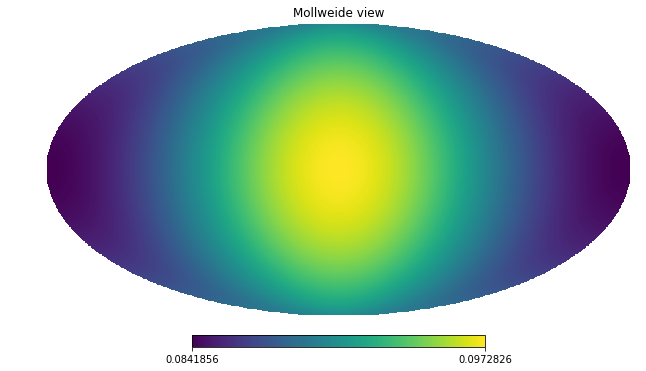

In [92]:
FermiData = np.load('fermi_data/fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
dif = np.load('fermi_data/template_dif.npy')
iso = np.load('fermi_data/template_iso.npy')
psc = np.load('fermi_data/template_psc.npy')
subhalos = np.load('EinastoTemplate.npy')
subhalos = subhalos
hp.mollview(subhalos)

In [93]:
fake_data = np.load("fake_data.npy")

In [94]:
LL_xsec_ary_arr = []
new_n_arr = []
d_arr_ary = []
n = nptfit.NPTF(tag='test22_fn_100')
n.load_data(fake_data, fermi_exposure)
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
n.load_mask(mask)

subhalos_copy = subhalos.copy()

area_mask = len(mask[~mask])/len(mask) * 4*np.pi * (180/np.pi)**2
xsec0 = 1e-22

#A0 = 10**(3.63193)/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])/.01
#n20 = 1.93186 
#n10 = 10
#Fb0 = 10**(-7.71429)*np.average(fermi_exposure[~mask])*.01

A0 = 10**(7.1671)/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])
n30 = -10
n20 = 1.45746
n10 = 1.95624
Fb0 = 10**(-10.8161+1.23587)*np.average(fermi_exposure[~mask])
Fb1 = 10**(-10.8161)*np.average(fermi_exposure[~mask])

n.add_template(subhalos_copy, 'subhalos', units='PS')
n.add_non_poiss_model('subhalos', 
                       ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$F_b1$'],
                       [[-10, 1], [-3., 3.]],
                       [True, False],
                          fixed_params=[[1,10.0], [3,Fb0]],
                          units='counts')

print(np.log10(A0))

-3.2827785781206904


In [95]:
n.configure_for_scan()
#n.perform_scan(nlive=100)

The number of parameters to be fit is 2


In [7]:
A_arr = np.linspace(-1,2,500)
ll = []
for A_val in A_arr:
    ll.append(n.ll([A_val]))
ll = np.array(ll)
plt.plot(A_arr, max(ll)-ll)
plt.xscale("log")
plt.yscale("log")
print(A_arr[np.argmax(ll)])

KeyboardInterrupt: 

In [96]:
n.load_scan()
cs = dnds_analysis.Analysis(n)
cs.make_triangle()

  analysing data from /tigress/somalwar/Subhaloes/Subhalos/chains/test22_fn_100/.txt


OSError: /tigress/somalwar/Subhaloes/Subhalos/chains/test22_fn_100/.txt not found.

28175950660.43686


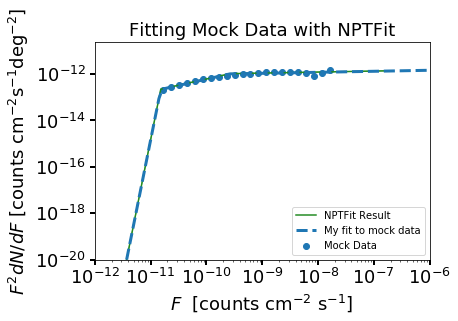

In [88]:
def dNdF(F):
    A = 10**(7.1671)
    n1 = 1.95624
    n2 = 1.45746
    n3 = -10
    Fb1 = 10**(1.23587-10.8161)
    Fb2 = 10**(-10.8161)
    return A*(F/Fb1)**(-n1)*(F>Fb1) + A*(F/Fb1)**(-n2)*(np.logical_and(F<=Fb1, F>Fb2)) + A*(F/Fb2)**(-n3)*(Fb2/Fb1)**(-n2)*(F<Fb2)

cs.plot_source_count_median('subhalos',smin=0.01,smax=10000,nsteps=1000,spow=2,color='forestgreen', label="NPTFit Result")
cs.plot_source_count_band('subhalos',smin=0.01,smax=10000,nsteps=1000,qs=[0.16,0.5,0.84],spow=2,color='forestgreen',alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-14, 1e-6)
plt.ylim(1e-20)
plt.tick_params(axis='x', length=5,width=2,labelsize=18)
plt.tick_params(axis='y',length=5,width=2,labelsize=18)
plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]', fontsize=18)
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]', fontsize=18)

F_test_arr = np.logspace(-12, -6, 100)
plt.plot(F_test_arr, F_test_arr**2 * dNdF(F_test_arr), label="My fit to mock data", linestyle="--", linewidth=3)
plt.scatter(F*.1, F2dNdF*.1, label="Mock Data")
plt.legend()
plt.title("Fitting Mock Data with NPTFit", fontsize=18)
plt.xlim(1e-12, 1e-6)
print(1/(1/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])))

In [83]:
F = np.array([1.66009661e-11, 2.30669676e-11, 3.20514476e-11, 4.45353420e-11,
       6.18816570e-11, 8.59842837e-11, 1.19474775e-10, 1.66009661e-10,
       2.30669676e-10, 3.20514476e-10, 4.45353420e-10, 6.18816570e-10,
       8.59842837e-10, 1.19474775e-09, 1.66009661e-09, 2.30669676e-09,
       3.20514476e-09, 4.45353420e-09, 6.18816570e-09, 8.59842837e-09,
       1.19474775e-08, 1.66009661e-08, 2.30669676e-08, 3.20514476e-08,
       4.45353420e-08, 6.18816570e-08, 8.59842837e-08, 1.19474775e-07,
       1.66009661e-07, 2.30669676e-07, 3.20514476e-07, 4.45353420e-07,
       6.18816570e-07, 8.59842837e-07])/.1
F2dNdF = np.array([2.03697809e-13, 2.66139445e-13, 3.34580554e-13, 4.15961522e-13,
       4.92980093e-13, 5.90511740e-13, 6.67350900e-13, 7.60066450e-13,
       8.44887126e-13, 9.09824313e-13, 9.78732994e-13, 1.01995881e-12,
       1.10228858e-12, 1.20341966e-12, 1.21610632e-12, 1.26733069e-12,
       1.17396686e-12, 1.22341624e-12, 1.13328757e-12, 7.87348987e-13,
       1.09401787e-12, 1.52013290e-12, 2.11221782e-62, 2.93491714e-62,
       4.07805414e-62, 5.66643785e-62, 7.87348987e-62, 1.09401787e-61,
       1.52013290e-61, 2.11221782e-61, 2.93491714e-61, 4.07805414e-61,
       5.66643785e-61, 7.87348987e-61])/.1